# Getting Started

In this assignment you will be implementing at least 2 unique models and working with both the CIFAR10 and Imagenette datasets. The cell below defines a basic model based on the examples we reviewed in class. You should use this as a starting point to implement your own models.

You should have no problems running this notebook in Google Colab. If you choose to run it on your own machine, a yaml file is provided with the necessary dependencies. If you are using anaconda, you can create a new environment with the following command:

```bash
conda env create -f env.yml
```

#Import torch and test cuda

In [1]:
import torch
torch.cuda.empty_cache()
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


CUDA available: True
Device: cuda


#Install Lighting

In [2]:
!pip install lightning

#BaselineModel (MLP) provided

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics


class BaselineModel(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.estimator = nn.Sequential(
            nn.Linear(64 * 64, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        return self.estimator(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        self.log("val_accuracy", self.accuracy)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        self.log("test_accuracy", self.accuracy)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


#Imagenette dataset preparation

The Imagenette dataset is a smaller subset of 10 easily classified classes from Imagenet. It is available to download from `torchvision`, as shown in the cell below. There are 3 different sizes of the images available. Feel free to use whichever version you prefer. It might make a difference in the performance of your model.

**Note: After downloading the Imagenette dataset, you will need to set `download=False` in the cell below to avoid errors.(Note: I had no issue without changing to the false.)**

In [9]:
from torchvision import transforms
from torchvision.datasets import Imagenette
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint


# Prepare the dataset. Without Data augementation.
# train_transforms = transforms.Compose([
#     transforms.CenterCrop(160),
#     transforms.Resize(64),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
#     transforms.Grayscale()
# ])

# Prepare the dataset for the Regularization. Use this for regularization.
train_transforms = transforms.Compose([
    transforms.Grayscale(),  # Convert to 1-channel before anything else
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize for 1-channel image
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=train_transforms)

# Use 10% of the training set for validation
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms

# Use DataLoader to load the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False)

# Configure the test dataset
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=test_transforms)

model = BaselineModel()

# Add EarlyStopping
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    mode="min",
                                    patience=5)

# Configure Checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min"
)

In [ ]:
# Fit the model
# trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback])
# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
# Evaluate the model on the test set
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False)
# trainer.test(model=model, dataloaders=test_loader)

#Basic Convulution Neural Network (CNN)

In [5]:
class BasicCNN(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Input: 1x64x64 -> Output: 32x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 32x32x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output: 64x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output: 64x16x16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Output: 128x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # Output: 128x8x8
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.log("val_accuracy", self.accuracy, prog_bar=True)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.log("test_accuracy", self.accuracy)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


**Note: When training and evaluating model, sometimes session might crashed likely due to the hardware limitations. In such case select runtime and restart the session and start running cells from the beginning.**

##Train and evaluate Basic CNN model

In [6]:
# Instantiate the model
model = BasicCNN()

# Create the Trainer with GPU and callbacks
trainer = L.Trainer(
    accelerator="auto",            # Automatically use GPU if available
    max_epochs=50,                 # Set a reasonable upper limit
    callbacks=[early_stop_callback, checkpoint_callback],
    log_every_n_steps=10
)

# Train the model
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Evaluate on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, shuffle=False)
trainer.test(model=model, dataloaders=test_loader)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 92.7 K | train
1 | fc_layers   | Sequential         | 2.1 M  | train
2 | accuracy    | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.771     Total estimated model params size (MB)
16        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6010190844535828     │
│         test_loss         │     2.269066095352173     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.6010190844535828, 'test_loss': 2.269066095352173}]

#ResNet 18 model

In [7]:
import torchvision.models as models
import lightning as L
import torch.nn.functional as F
import torchmetrics
import torch
from torch import nn

class ResNet18Classifier(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.resnet18(pretrained=False)

        # Since we're using grayscale images, change the input layer from 3 channels to 1
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the final FC layer to match the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.log("val_accuracy", self.accuracy, prog_bar=True)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.log("test_accuracy", self.accuracy)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


##Train and Evaluate ResNet 18

In [8]:
# Instantiate the model
resnet_model = ResNet18Classifier()

# Define Trainer and callbacks
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    callbacks=[early_stop_callback, checkpoint_callback],
    log_every_n_steps=10
)

# Train the model
trainer.fit(model=resnet_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Evaluate on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, shuffle=False)
trainer.test(model=resnet_model, dataloaders=test_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint director

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.499872624874115     │
│         test_loss         │    1.5042179822921753     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.499872624874115, 'test_loss': 1.5042179822921753}]

#Regularization for ResNet 18 model using data augmentation technique.
**Steps**
- Go back to the Imagenette dataset preparation section.
- Uncomment the train_transform section for the regularization and comment the regular train_transform above it.
- Re-run the cell.
- Comback and run the ResNet 18 with augmentation model below.

##Train and evaluate ResNet 18 model with Data Augmentation.

In [10]:
# Instantiate the model
resnet_model_augmented = ResNet18Classifier()

# Define Trainer and callbacks
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    callbacks=[early_stop_callback, checkpoint_callback],
    log_every_n_steps=10
)

# Train the model
trainer.fit(model=resnet_model_augmented, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Evaluate on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, shuffle=False)
trainer.test(model=resnet_model_augmented, dataloaders=test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5768153071403503     │
│         test_loss         │     2.017526149749756     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.5768153071403503, 'test_loss': 2.017526149749756}]

**Notes**
- Go back and undo the comment in the previous steps.
- Run the dataset cell again.
- Open Files in the sidebar of google colab.
- Check the content/data/lighting_logs/version_X.
- Note the latest one which is for the ResNet18 with augmented model. We will need this later for transfer learning.
- Not to view the inside of the version folder, sometimes it takes time to load the files, so leave the downarrow on and wait.

#Transfer Learning with ResNet18 on CIFAR10 dataset.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision import models
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

##CIFAR10 Transfer Learning Model

In [12]:
class CIFAR10TransferModel(L.LightningModule):
    def __init__(self, lr=1e-3, batch_size=64):
        super().__init__()
        self.save_hyperparameters()

        self.train_losses = []
        self.val_losses = []
        self.train_loss_epoch = []
        self.val_loss_epoch = []

        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.val_losses.append(loss.item())
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_accuracy", acc, prog_bar=True)
        return {"test_loss": loss, "test_accuracy": acc}

    def on_train_epoch_end(self):
        avg_train = sum(self.train_losses) / len(self.train_losses)
        avg_val = sum(self.val_losses) / len(self.val_losses)
        self.train_loss_epoch.append(avg_train)
        self.val_loss_epoch.append(avg_val)
        print(f"\nEpoch {self.current_epoch} - Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")
        self.train_losses.clear()
        self.val_losses.clear()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.lr)

    def prepare_data(self):
        CIFAR10(root="data", train=True, download=True)
        CIFAR10(root="data", train=False, download=True)

    def setup(self, stage=None):
        transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        dataset = CIFAR10("data", train=True, transform=transform)
        test_set = CIFAR10("data", train=False, transform=transform)
        self.train_dataset, self.val_dataset = random_split(dataset, [45000, 5000])
        self.test_dataset = test_set

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.hparams.batch_size, num_workers=2)


def plot_loss(model, title):
    epochs = range(len(model.train_loss_epoch))
    plt.plot(epochs, model.train_loss_epoch, label="Train Loss")
    plt.plot(epochs, model.val_loss_epoch, label="Val Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

## Train from Scratch

**Note this model takes time to converge in the first run.It took me 12-15 min.**

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
100%|██████████| 170M/170M [00:04<00:00, 42.1MB/s]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 11.2 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
69        Modules in train mode
0         Modules 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 0 - Train Loss: 1.3384, Val Loss: 1.1386


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 1 - Train Loss: 0.8446, Val Loss: 0.9495


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 2 - Train Loss: 0.6428, Val Loss: 0.9880


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 3 - Train Loss: 0.5198, Val Loss: 0.7323


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.



Epoch 4 - Train Loss: 0.4163, Val Loss: 0.7392


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7705000042915344     │
│         test_loss         │    0.7157152891159058     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy (From Scratch): 0.7705000042915344


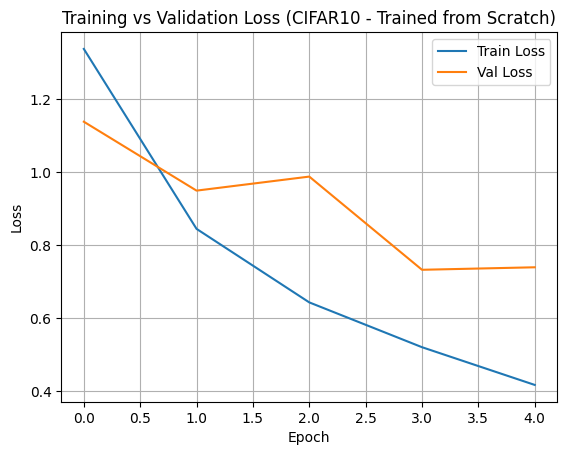

In [13]:
# Train from Scratch
model_scratch = CIFAR10TransferModel()

trainer = L.Trainer(
    max_epochs=5,
    accelerator="auto",
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3),
        ModelCheckpoint(monitor="val_loss", mode="min")
    ],
    log_every_n_steps=10
)

trainer.fit(model_scratch)
test_results = trainer.test(model_scratch)
print("Test Accuracy (From Scratch):", test_results[0]["test_accuracy"])
plot_loss(model_scratch, "Training vs Validation Loss (CIFAR10 - Trained from Scratch)")

##Fine-Tune with Imagenette-Trained Weights

**Note: For the pretrained path we should keep track of the ResNet18 with augemented model in the lighting logs and use its version folder and ckpt file inside the checkpoints folder inside it as shown below.The version folder will keep on increasing each time you run a model. If you are running this make sure you remember the version folder from previous ResNet 18 augmented model.**

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 11.2 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 0 - Train Loss: 1.2330, Val Loss: 1.7107


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 1 - Train Loss: 0.7786, Val Loss: 0.9211


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 2 - Train Loss: 0.6070, Val Loss: 0.6601


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 3 - Train Loss: 0.4850, Val Loss: 0.6839


Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 4 - Train Loss: 0.3777, Val Loss: 0.5747


INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8004000186920166     │
│         test_loss         │    0.6070336103439331     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy (Fine-Tuned): 0.8004000186920166


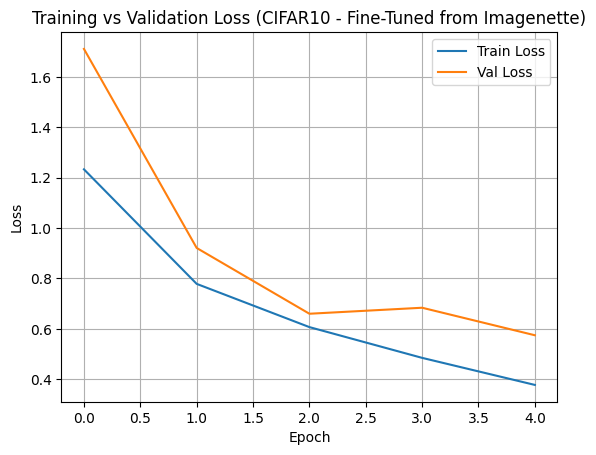

In [14]:
# Fine-tune from Imagenette checkpoint
checkpoint_path = "/content/lightning_logs/version_3/checkpoints/epoch=2-step=201.ckpt"
model_finetune = CIFAR10TransferModel.load_from_checkpoint(checkpoint_path)

trainer_finetune = L.Trainer(
    max_epochs=5,
    accelerator="auto",
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3),
        ModelCheckpoint(monitor="val_loss", mode="min")
    ],
    log_every_n_steps=10
)

trainer_finetune.fit(model_finetune)
test_results_ft = trainer_finetune.test(model_finetune)
print("Test Accuracy (Fine-Tuned):", test_results_ft[0]["test_accuracy"])
plot_loss(model_finetune, "Training vs Validation Loss (CIFAR10 - Fine-Tuned from Imagenette)")